## CNN - GTSRB

## Imports

In [3]:
import mypackage
from mypackage import dcaiti_utils
from mypackage traffic_sign_dataset, custom_tranform
from mypackage import build, training

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Reset warnings to default behavior
# warnings.resetwarnings()

In [2]:
import os
import sys
import numpy as np
from pathlib import Path

import dcaiti_utils as du
from traffic_sign_dataset import TrafficSignDataset, get_data_loader, To_Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

# For Plotting
import matplotlib.pyplot as plt
%matplotlib inline


def show(example):
#     image, _ = example
    im_array = np.asarray(transforms.ToPILImage()(example))
    du.show(im_array)

### Choose GPU

In [3]:
# ! nvidia-smi

In [4]:
import torch
gpu = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(f"cuda:{gpu}")

## Dataset

In [5]:
SCALE = 64
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

transform_test_data = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((SCALE, SCALE)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std),
])

# PATH="/srv/store/dlenv/pjstuds/datacollections"
PATH="/srv/store/docker-users/pjstuds/obada.kiddeh" # root directory
data_dir = PATH + '/FinalDataset' # path to the dataset

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

### Load dataset

In [6]:
orig_dataset = TrafficSignDataset(data_dir + '/Final_Training/', transform=transform) # Load the train dataset
idx_to_class = {v: k for k, v in orig_dataset.class_to_idx.items()}

num_classes = len(orig_dataset.class_to_idx) # #classes
print("# of Classes: ", num_classes)
print("# of Images :", len(orig_dataset))

# of Classes:  50
# of Images : 40995


### Load Test dataset

In [7]:
test_set = TrafficSignDataset(data_dir +'/Final_Test_Full',
                             transform=transform_test_data,
                             test_labels_path=data_dir + '/Final_Test_Full/GT-final_test.csv')

print("# of Test Images :", len(test_set))

# of Test Images : 12934


### Split dataset into Train and Validation

In [8]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(
    orig_dataset.images,  # Input data
    orig_dataset.targets,  # Target labels
    test_size=0.3,  # Validation set size 0.4
#     stratify=orig_dataset.targets, # Maintain data-class distribution
    shuffle=True, # schuffe because the classes are in order
    random_state=42,
)

# Create training and validation datasets
train_set = To_Dataset(train_data, train_labels, orig_dataset.dataset.classes)
validation_set = To_Dataset(val_data, val_labels, orig_dataset.dataset.classes)

### Data Distibution

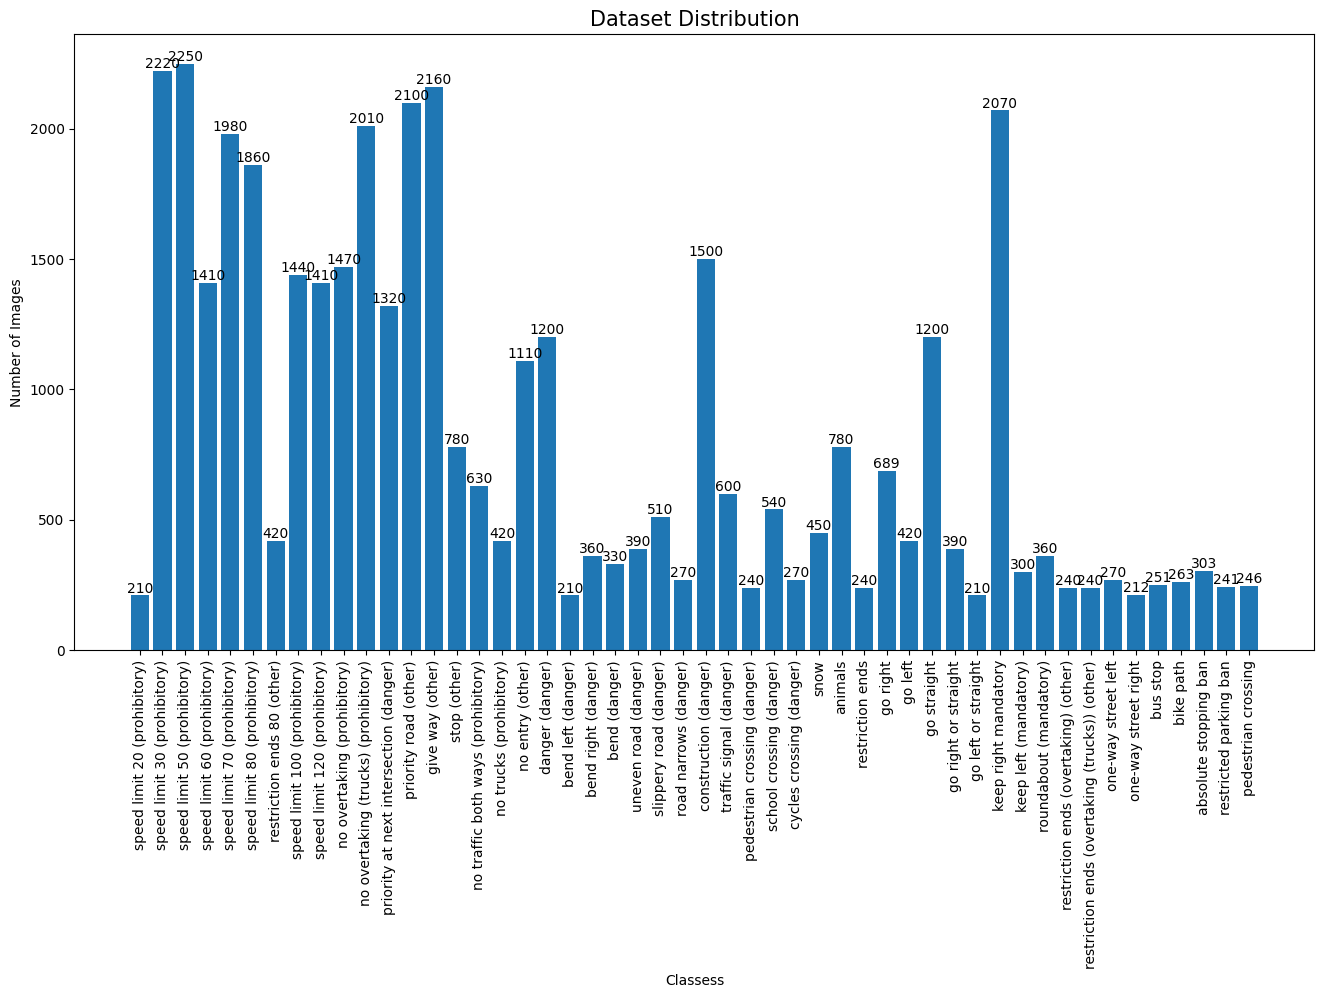

In [9]:
du.visualize_data_distribution(orig_dataset, orig_dataset.labels_dictionary, titel='Dataset Distribution')

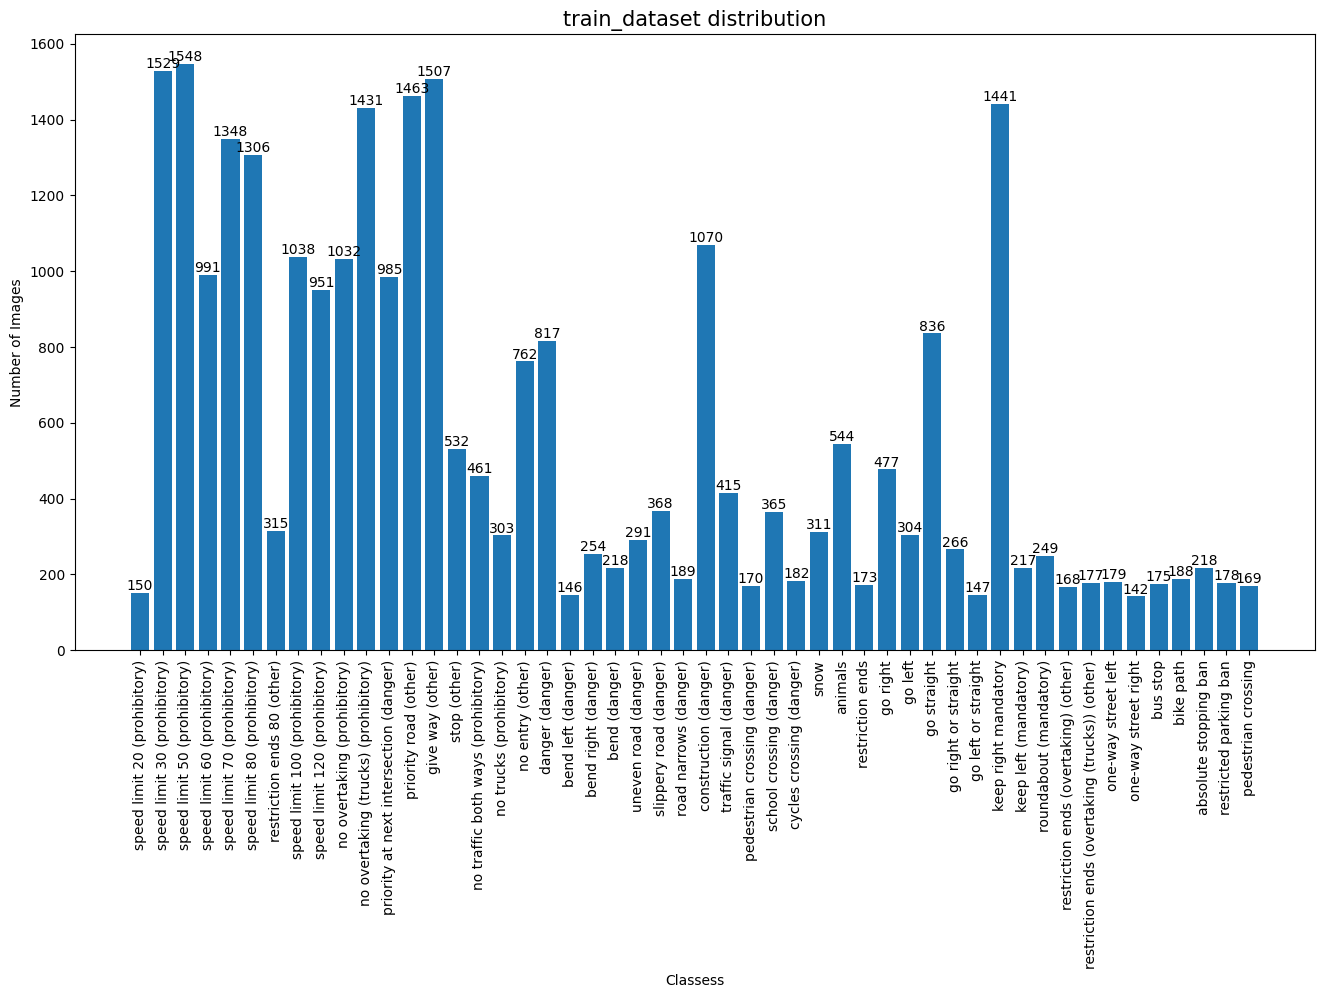

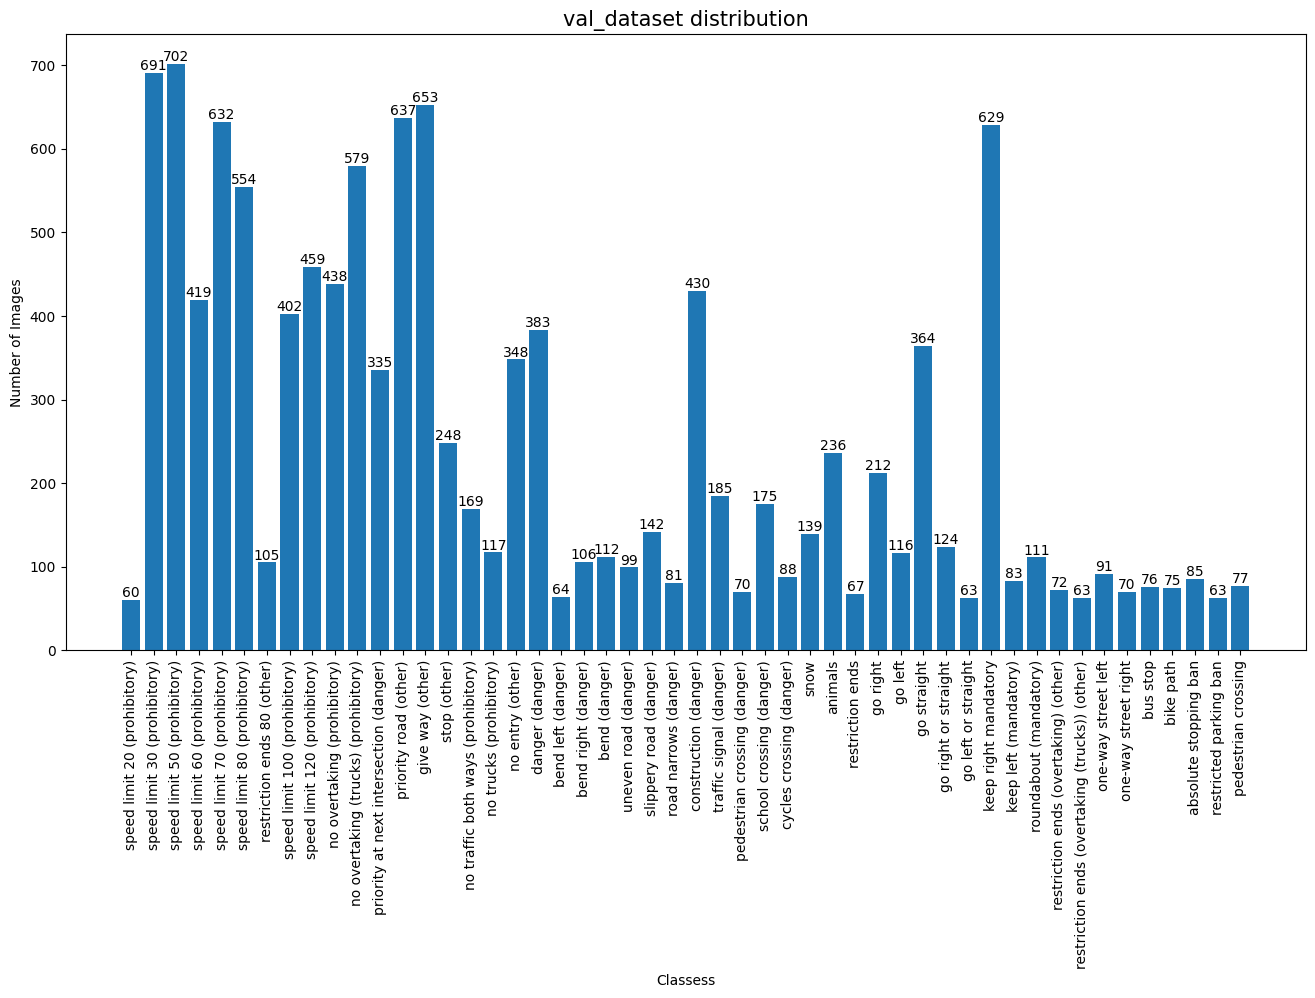

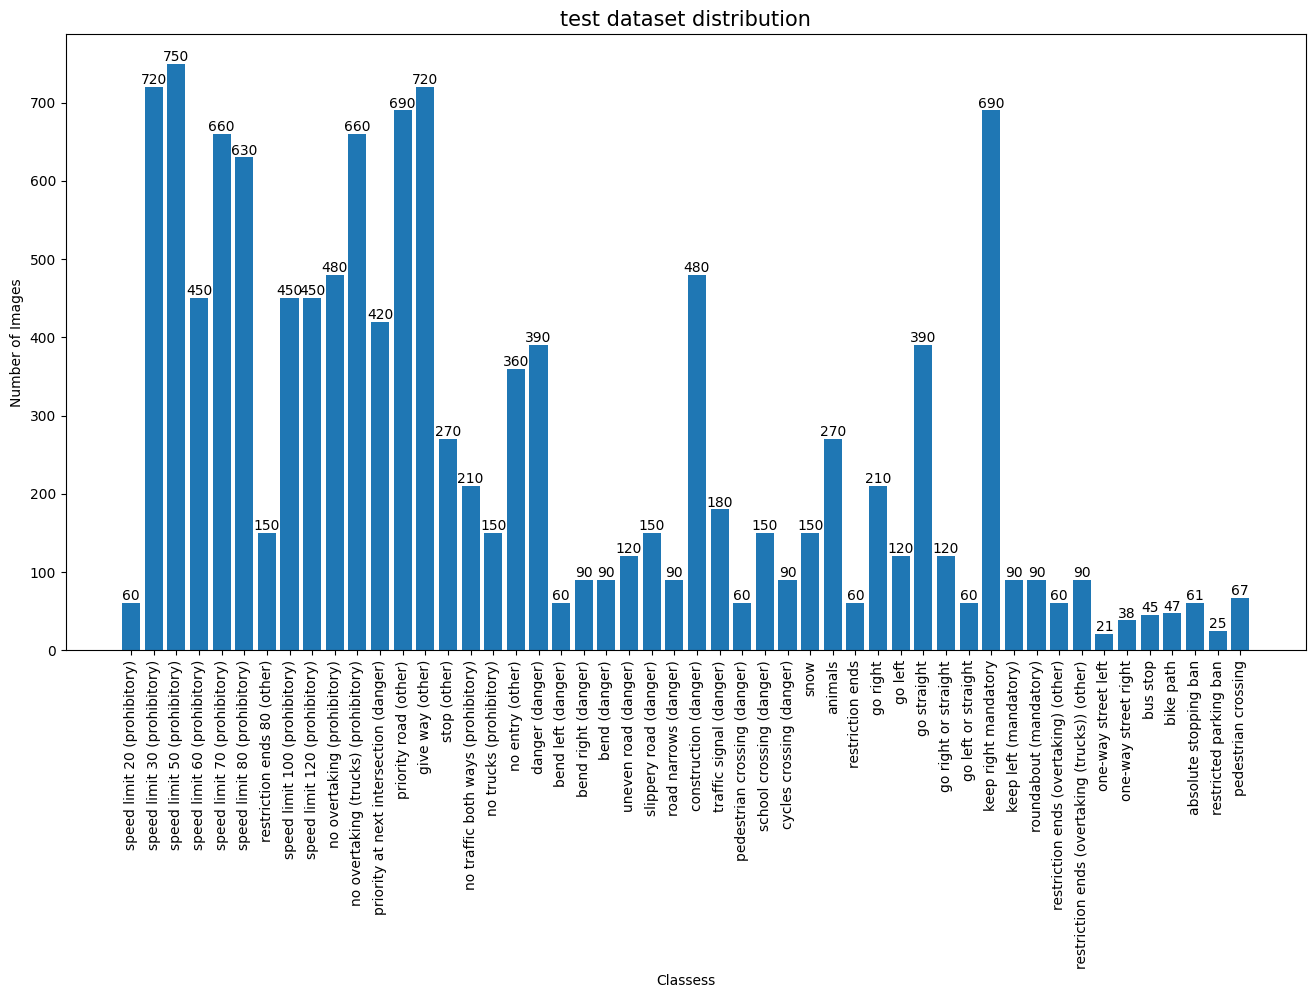

In [43]:
# du.visualize_data_distribution(train_set, orig_dataset.labels_dictionary, titel='train_dataset distribution')

# du.visualize_data_distribution(validation_set, orig_dataset.labels_dictionary, titel='val_dataset distribution')

# du.visualize_data_distribution(test_set, orig_dataset.labels_dictionary, titel='test dataset distribution')

### Augmentation

Classes with arrows : [19, 20, 33, 34, 35, 36, 37, 38, 39, 43, 44]

#### Define augmentation configurations

In [11]:
from custom_tranform import CustomTransformDataset, CustomNoiseTransform, CustomBlurTransform
from custom_tranform import CustomBrightnessTransform, CustomSaturationTransform, CustomContrastTransform
from custom_tranform import CustomColorTransform, CustomRotationTransform, CustomResizeTransform

# Define augmentation configurations
all_classes = orig_dataset.labels_dictionary.keys()
desired_classes_1 = list(set(all_classes) - set([1,2,3,4,5,7,8,9,10,11,12,13,14,15,17,18,25,31,35,38]))
desired_classes_2 = list(set(all_classes) - set([1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,23,26,25,28,33,35,38]))

augmentations = [
    # Only Resizing
    (CustomResizeTransform, {"desired_classes": list(all_classes),}),
    # Add noise
    (CustomNoiseTransform, {"noise_std": 0.01,
                            "noise_mean": 3,
                            "desired_classes": desired_classes_1,}),
    # Add some noise
    (CustomNoiseTransform, {"noise_std": 0.1,
                            "noise_mean": 0.1,
                            "desired_classes": [17,18,35],}),
    # Add Blur
    (CustomBlurTransform, {"radius": 1,
                           "desired_classes": desired_classes_1,}),
    # Brightness
    (CustomBrightnessTransform, {"brightness_factor": (0.3, 0.6),
                                 "desired_classes": desired_classes_2,}),
    # Saturation
    (CustomSaturationTransform, {"saturation_factor": (4, 5),
                                 "desired_classes": desired_classes_1,}),
    # Contrast
    (CustomContrastTransform, {"contrast_factor": (4, 5),
                               "desired_classes": desired_classes_1,}),
    # Brightness & Saturation & Contrast
    (CustomColorTransform, {"brightness_factor": (1, 3),
                            "saturation_factor": (1, 3),
                            "contrast_factor": (1, 3), 
                            "desired_classes": desired_classes_2,}),
    # Rotation
    (CustomRotationTransform, {"rotation_factor": 15,
                               "desired_classes": desired_classes_2,}),
]

#### Apply augmentation

In [12]:
from custom_tranform import apply_augmentation

full_train_set = apply_augmentation(train_set, SCALE, augmentations) # Concatenate all training sets
# Do resizig on the validation images
resized_val_set = CustomResizeTransform(validation_set, 
                                        resize_scale=SCALE, 
                                        desired_classes=list(all_classes))

In [13]:
len(full_train_set), len(resized_val_set)

(78721, 12299)

#### Data distribution after augmenting

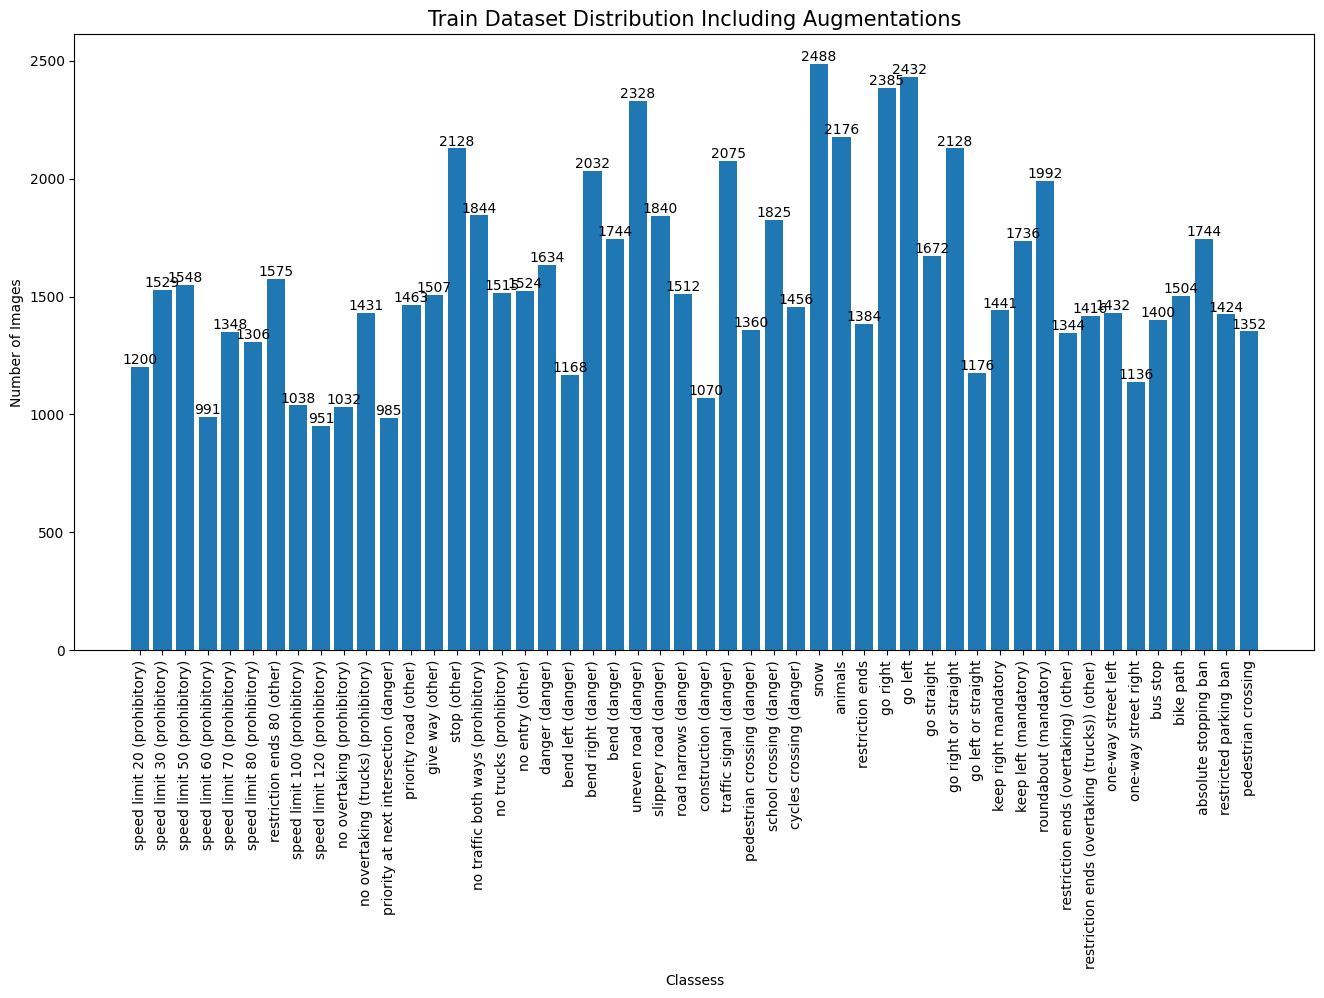

In [14]:
du.visualize_data_distribution(full_train_set, orig_dataset.labels_dictionary,
                               titel='Train Dataset Distribution Including Augmentations')

### Define data loaders

In [15]:
batch_size = 64
train_loader = get_data_loader(full_train_set, batch_size, shuffle=False)
validation_loader = get_data_loader(resized_val_set, batch_size, shuffle=False)
test_loader = get_data_loader(test_set, batch_size, shuffle=False)

In [16]:
len(train_loader), len(validation_loader), len(test_loader)

(1230, 192, 202)

### Define model configs

In [17]:
import build
from training import EarlyStopping
from torch.optim.lr_scheduler import StepLR

# configs
num_epochs = 20

# ResNet configs
resnet_config = {
    'depth': [18, 50, 101],
    'linear_layer_input_size': [256, 512, 1024, 2048],
    'lr': 0.001,
    'decay': 0.1,
}


# MicronNet configs
micronnet_config = {
    'linear_layer_input_size': [296, 1184, 1850, 2664],
    # image scale 32 --> 296
    # image scale 48 --> 1184
    # image scale 56 --> 1850
    # image scale 64 --> 2664
    'lr': 0.007,
    'decay': 0.1,
    'momentum': 0.8,
    'l2_norm': 0.00001,
    'decay': 0.9,
}

ce_criterion = nn.CrossEntropyLoss()
nll_criterion = F.nll_loss # Negative Log Likelihood Loss

early_stopping = EarlyStopping(patience=3, verbose=True) # Define early stopping criteria

##### ResNet-based model

In [18]:
depth = resnet_config['depth'][1] # 50
head_in_channels = resnet_config['linear_layer_input_size'][2] # 1024
head_mid_channels = [head_in_channels//2] # 512

res_net = build.ResNet(depth=depth, head_in_channels=head_in_channels, head_mid_channels=head_mid_channels, 
                       num_classes=num_classes)

##### Macro-achitect-based model

In [19]:
# image scale 32 --> i = 0
# image scale 48 --> i = 1
# image scale 56 --> i = 2
# image scale 64 --> i = 3

i = 3

in_channels = micronnet_config['linear_layer_input_size'][i] # 296

mircon_net = build.MicronNet(in_channels, num_classes)

### Choose model & optimization strategie

In [20]:
model = mircon_net

adam_lr = 0.001
adam_decay = 0.1
adam_optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

# sgd_optimizer = torch.optim.SGD(model.parameters(), lr=micronnet_config['lr'], 
#                                 momentum=micronnet_config['momentum'], 
#                                 weight_decay=micronnet_config['l2_norm'], nesterov=True)


optimizer = adam_optimizer # optimizer
criterion = ce_criterion # loss function
decay = adam_decay # micronnet_config['decay']
scheduler = StepLR(optimizer, step_size=2, gamma=decay) # Define scheduler

In [21]:
model

MicronNet(
  (conv1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv0_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 29, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv2_bn): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(29, 59, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (conv3_bn): BatchNorm2d(59, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(59, 74, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4_bn): 

### Start training

In [22]:
# start train
resnet_train_history, resnet_val_history = training.train_val_loop(model, 
                                                            device, 
                                                            train_loader, 
                                                            validation_loader, 
                                                            optimizer, 
                                                            criterion, 
                                                            num_epochs,
                                                            early_stopping,
                                                            scheduler,
                                                         )
# Print last epoch report
trained_epochs = len(resnet_train_history)
print(resnet_val_history[trained_epochs-1]['report'])

Epoch 1 - Training: Average loss: 2.2138

Validation: Average loss: 3.1339, Accuracy: 3295/12288 (26.8148%)

Epoch 1 - Training Time: 142.32 seconds


Epoch 2 - Training: Average loss: 1.7993

Validation: Average loss: 2.1179, Accuracy: 4096/12288 (33.3333%)

Epoch 2 - Training Time: 280.64 seconds


Epoch 3/20:  88%|██████████████  | 1080/1230 [01:50<00:24,  6.17it/s, loss=1.37]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 6 - Training: Average loss: 1.6968

Validation: Average loss: 0.1592, Accuracy: 12158/12288 (98.9421%)

Epoch 6 - Training Time: 825.22 seconds


Epoch 7 - Training: Average loss: 1.6960

Validation: Average loss: 0.1543, Accuracy: 12162/12288 (98.9746%)

Epoch 7 - Training Time: 957.80 seconds


Epoch 8 - Training: Average loss: 1.6776

Validation: Average loss: 0.1498, Accuracy: 12163/12288 (98.9827%)

Epoch 8 - Training Time: 1089.79 seconds


Epoch 9/20:  16%|██▉               | 200/1230 [00:09<00:46, 22.37it/s, loss=1.7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



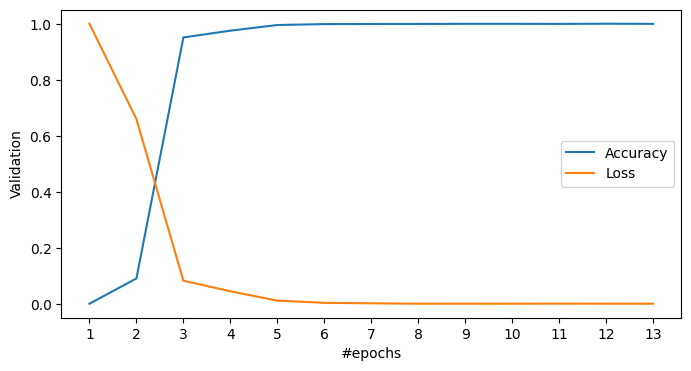

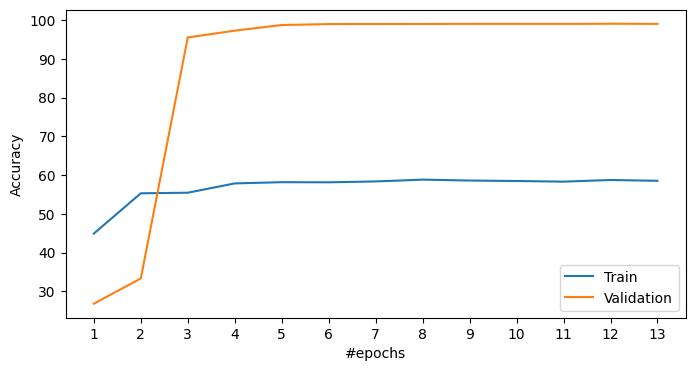

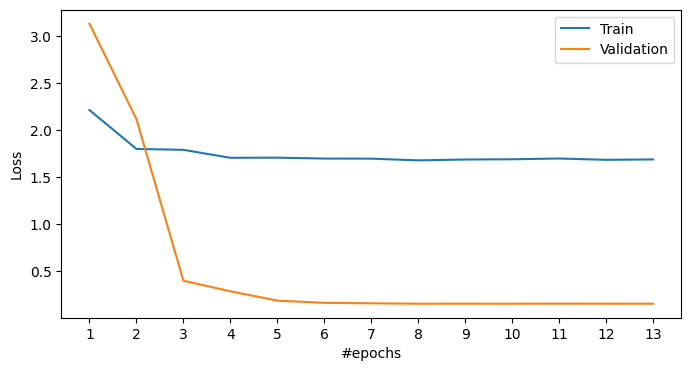

In [33]:
# visualize loss
training.visualize_loss_accuracy(resnet_train_history, resnet_val_history)

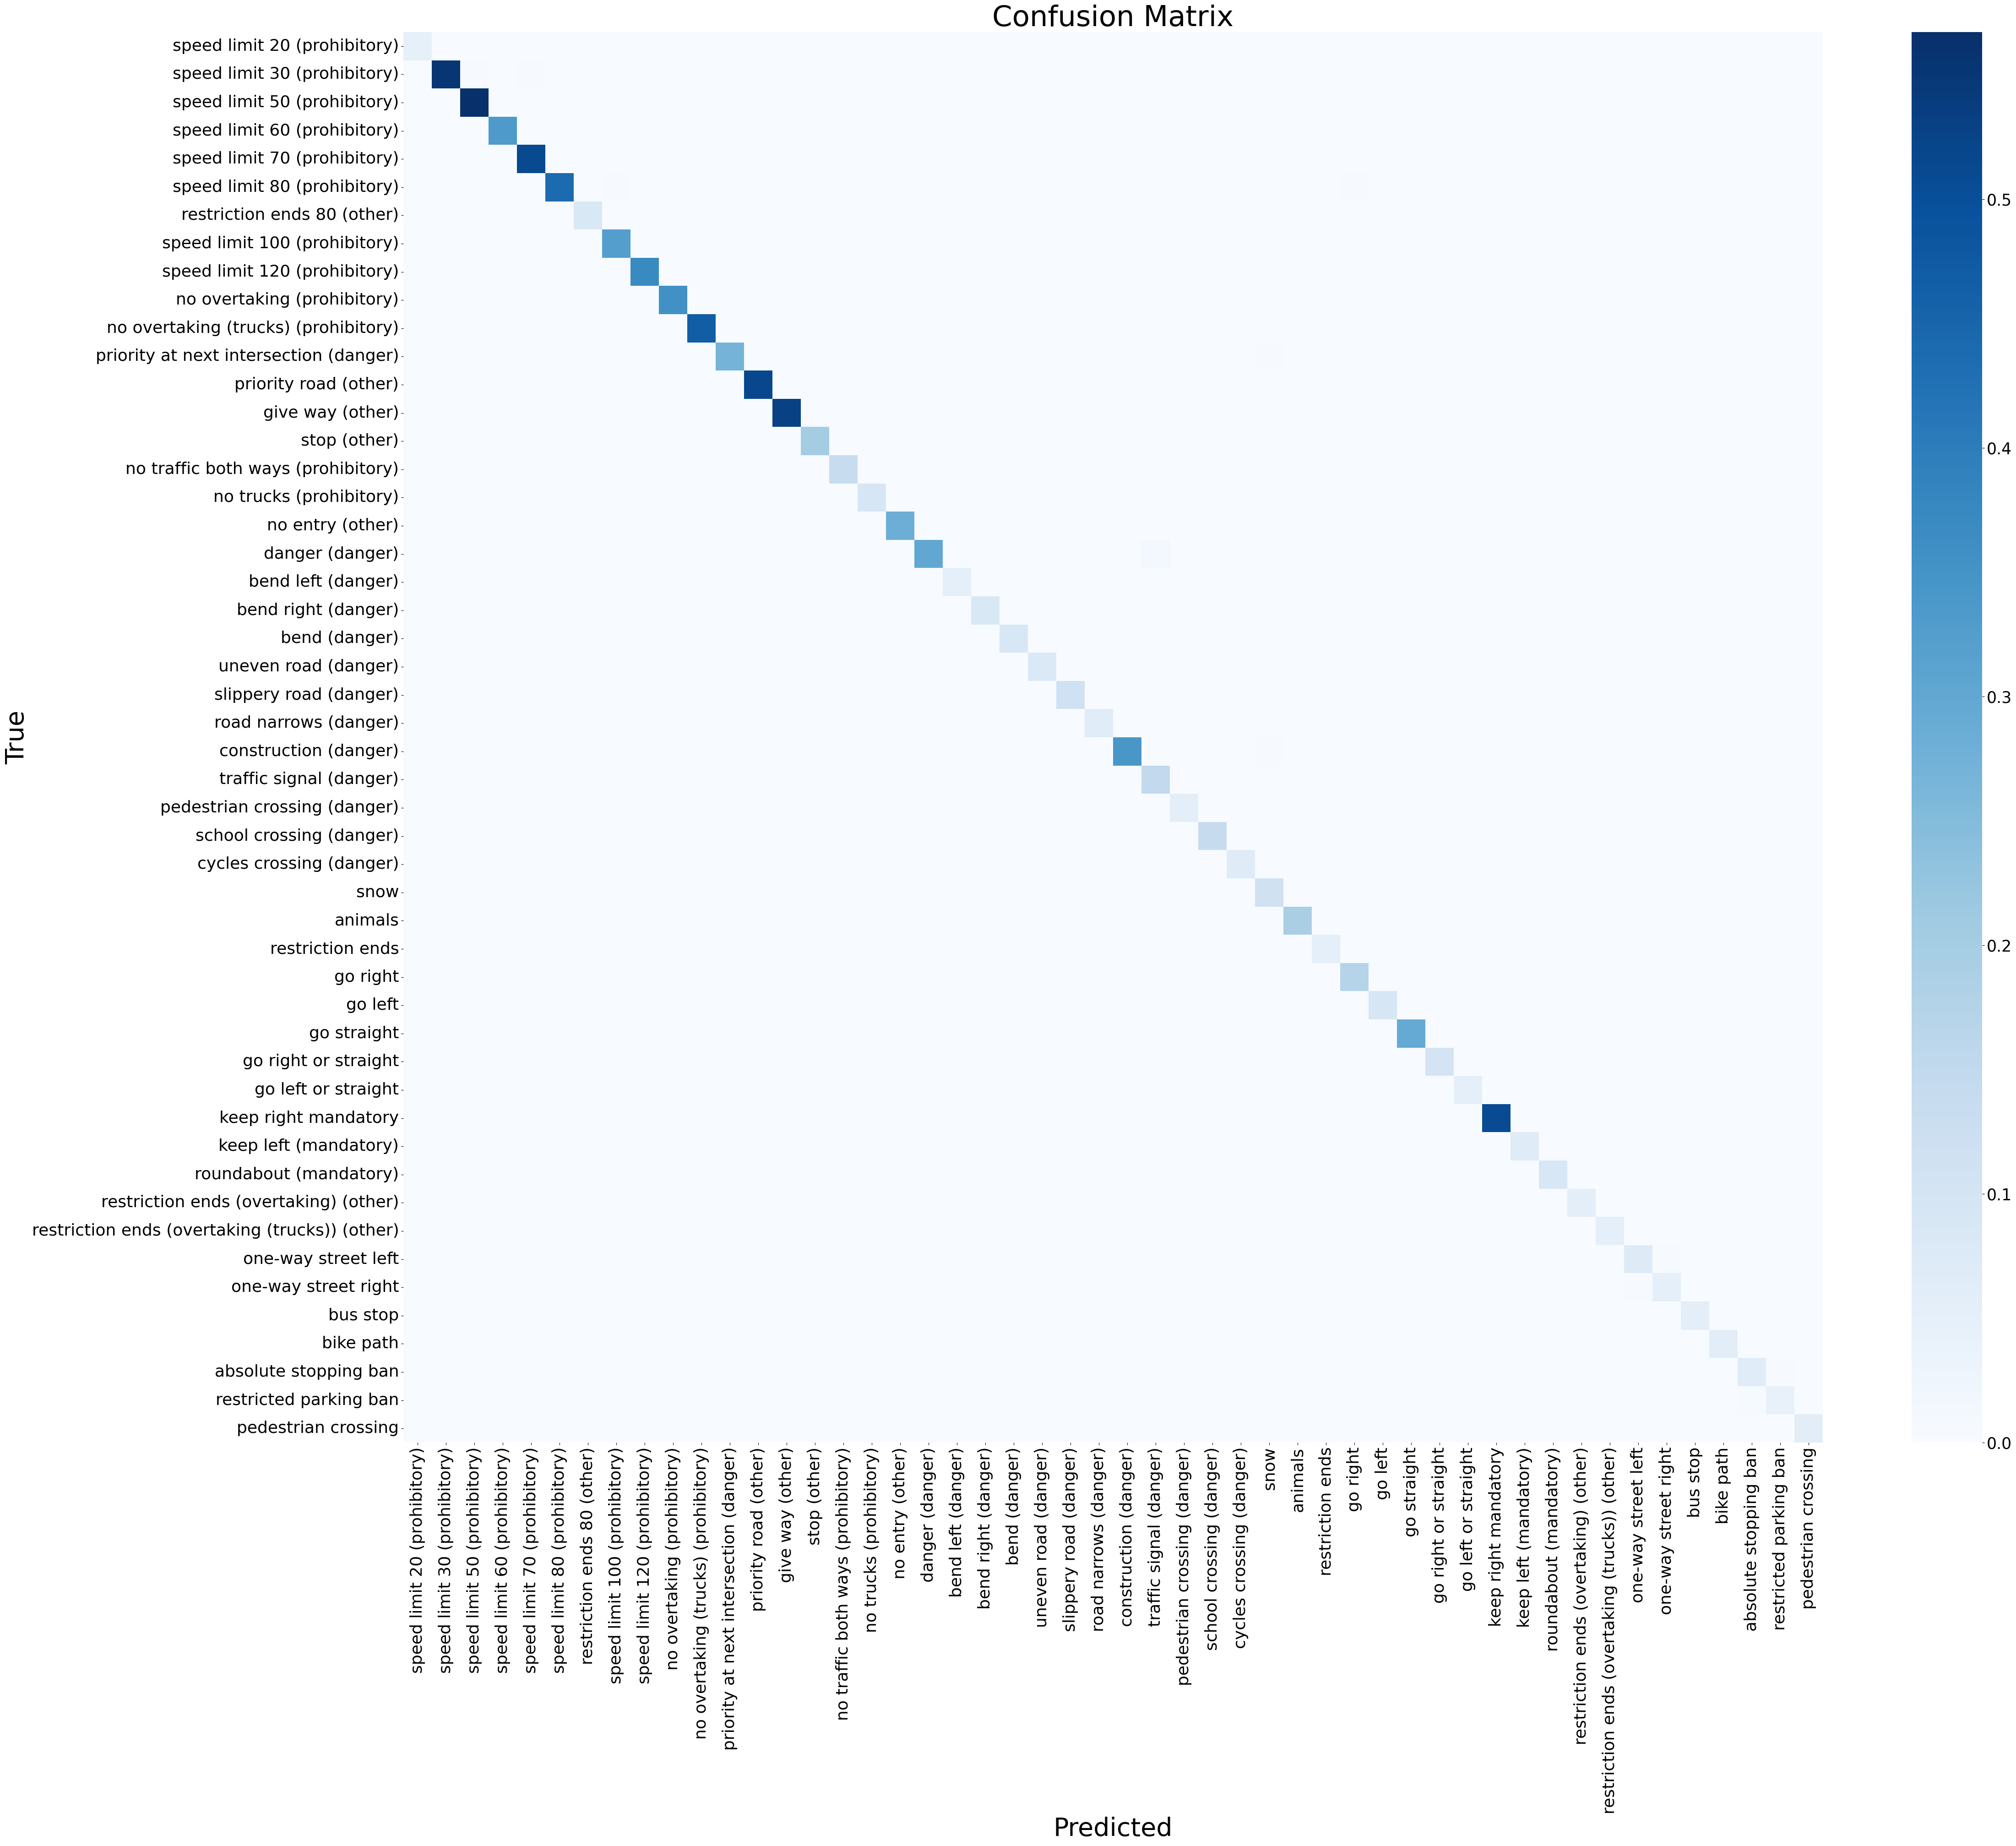

In [34]:
# visualize confusion matrix for validation set
training.visualize_confusion_matrix(resnet_val_history[trained_epochs-1]['confusion_matrix'],
                              orig_dataset.labels_dictionary)

### Testing

In [35]:
# Test model on test set
test_history = training.validation(model, device, test_loader, criterion)
print(test_history['report'])


Validation: Average loss: 0.2421, Accuracy: 12619/12928 (97.6098%)

              precision    recall  f1-score   support

           0     0.9375    1.0000    0.9677        60
           1     0.9986    0.9791    0.9888       719
           2     0.9881    0.9987    0.9934       750
           3     0.9930    0.9422    0.9669       450
           4     1.0000    0.9788    0.9893       660
           5     0.9568    0.9841    0.9703       630
           6     0.9792    0.9400    0.9592       150
           7     0.9861    0.9444    0.9648       450
           8     0.9933    0.9822    0.9877       450
           9     1.0000    1.0000    1.0000       480
          10     0.9954    0.9803    0.9878       660
          11     0.9805    0.9618    0.9711       419
          12     1.0000    0.9652    0.9823       690
          13     0.9986    0.9958    0.9972       720
          14     1.0000    0.9889    0.9944       270
          15     0.9906    1.0000    0.9953       210
          16

In [36]:
# Get class accuracies
accuracy_per_class = training.get_accuracy_per_class(test_history['confusion_matrix'],)

# Print accuracy for each class
for i, accuracy in enumerate(accuracy_per_class):
    print(f"Accuracy for Class {i}: {orig_dataset.labels_dictionary[i]}: {accuracy:.4f}")

Accuracy for Class 0: speed limit 20 (prohibitory): 1.0000
Accuracy for Class 1: speed limit 30 (prohibitory): 0.9791
Accuracy for Class 2: speed limit 50 (prohibitory): 0.9987
Accuracy for Class 3: speed limit 60 (prohibitory): 0.9422
Accuracy for Class 4: speed limit 70 (prohibitory): 0.9788
Accuracy for Class 5: speed limit 80 (prohibitory): 0.9841
Accuracy for Class 6: restriction ends 80 (other): 0.9400
Accuracy for Class 7: speed limit 100 (prohibitory): 0.9444
Accuracy for Class 8: speed limit 120 (prohibitory): 0.9822
Accuracy for Class 9: no overtaking (prohibitory): 1.0000
Accuracy for Class 10: no overtaking (trucks) (prohibitory): 0.9803
Accuracy for Class 11: priority at next intersection (danger): 0.9618
Accuracy for Class 12: priority road (other): 0.9652
Accuracy for Class 13: give way (other): 0.9958
Accuracy for Class 14: stop (other): 0.9889
Accuracy for Class 15: no traffic both ways (prohibitory): 1.0000
Accuracy for Class 16: no trucks (prohibitory): 1.0000
Accura

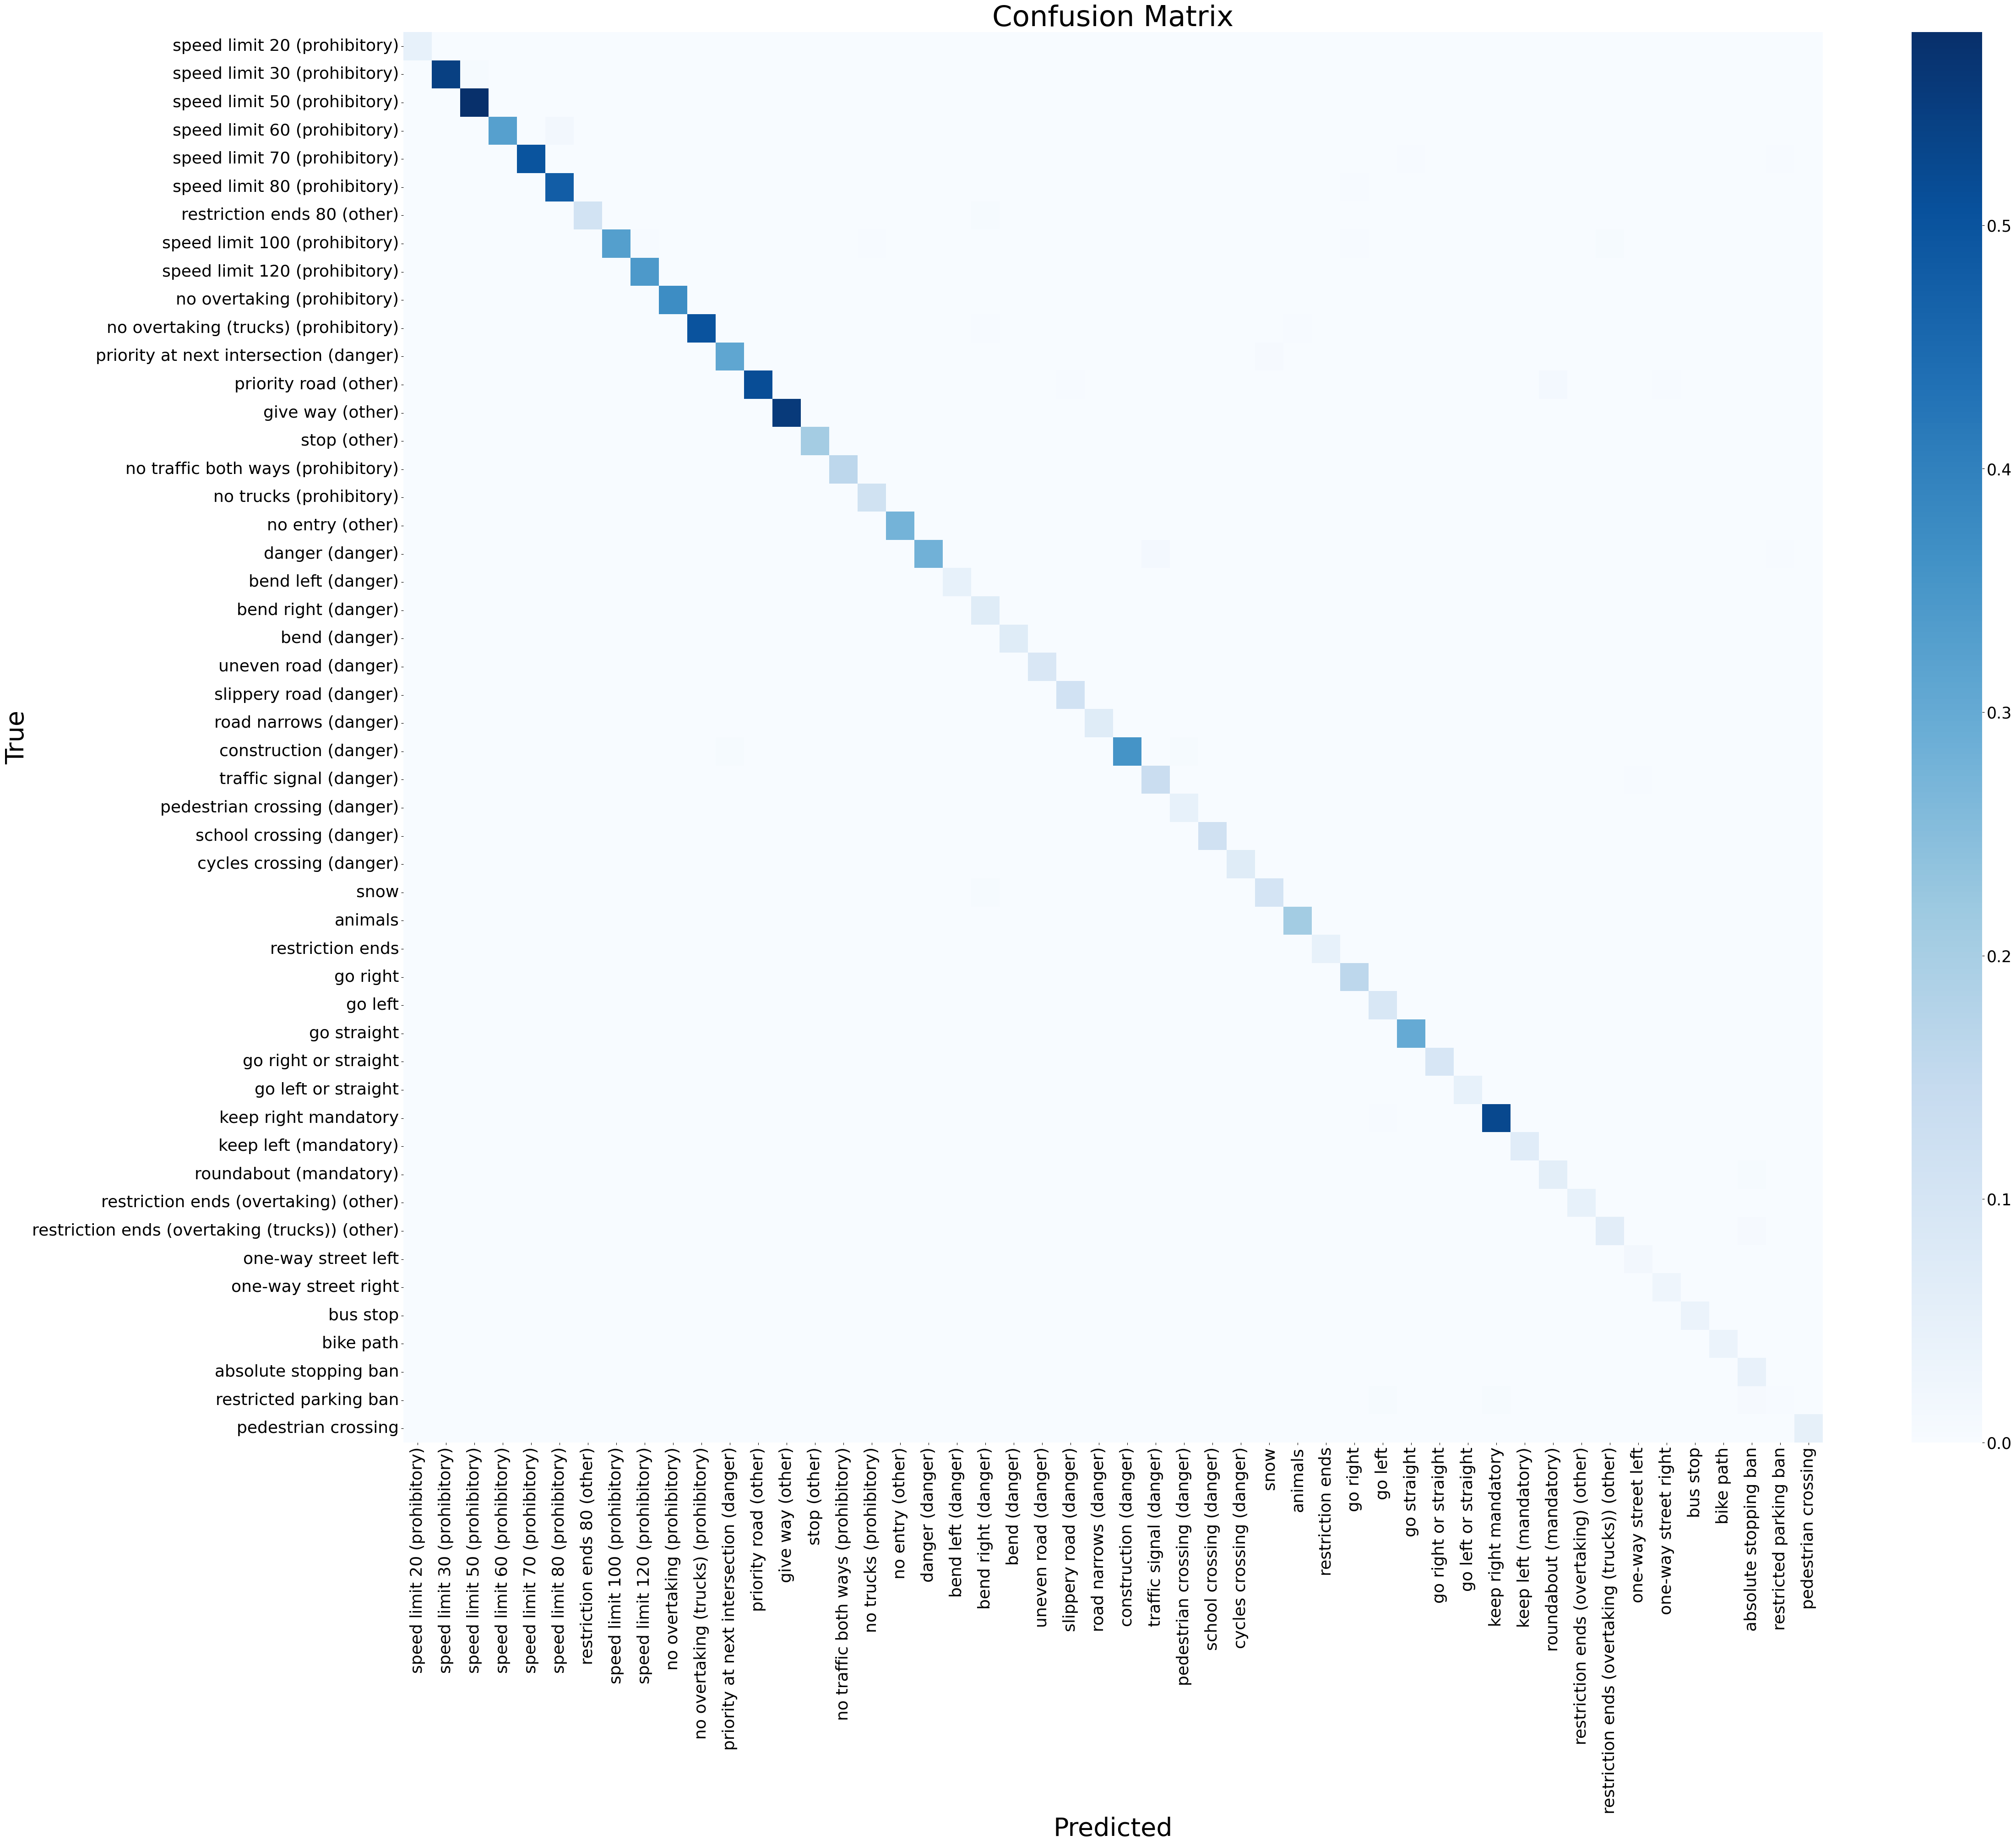

In [37]:
# visualize confusion matrix of test set
training.visualize_confusion_matrix(test_history['confusion_matrix'], orig_dataset.labels_dictionary)

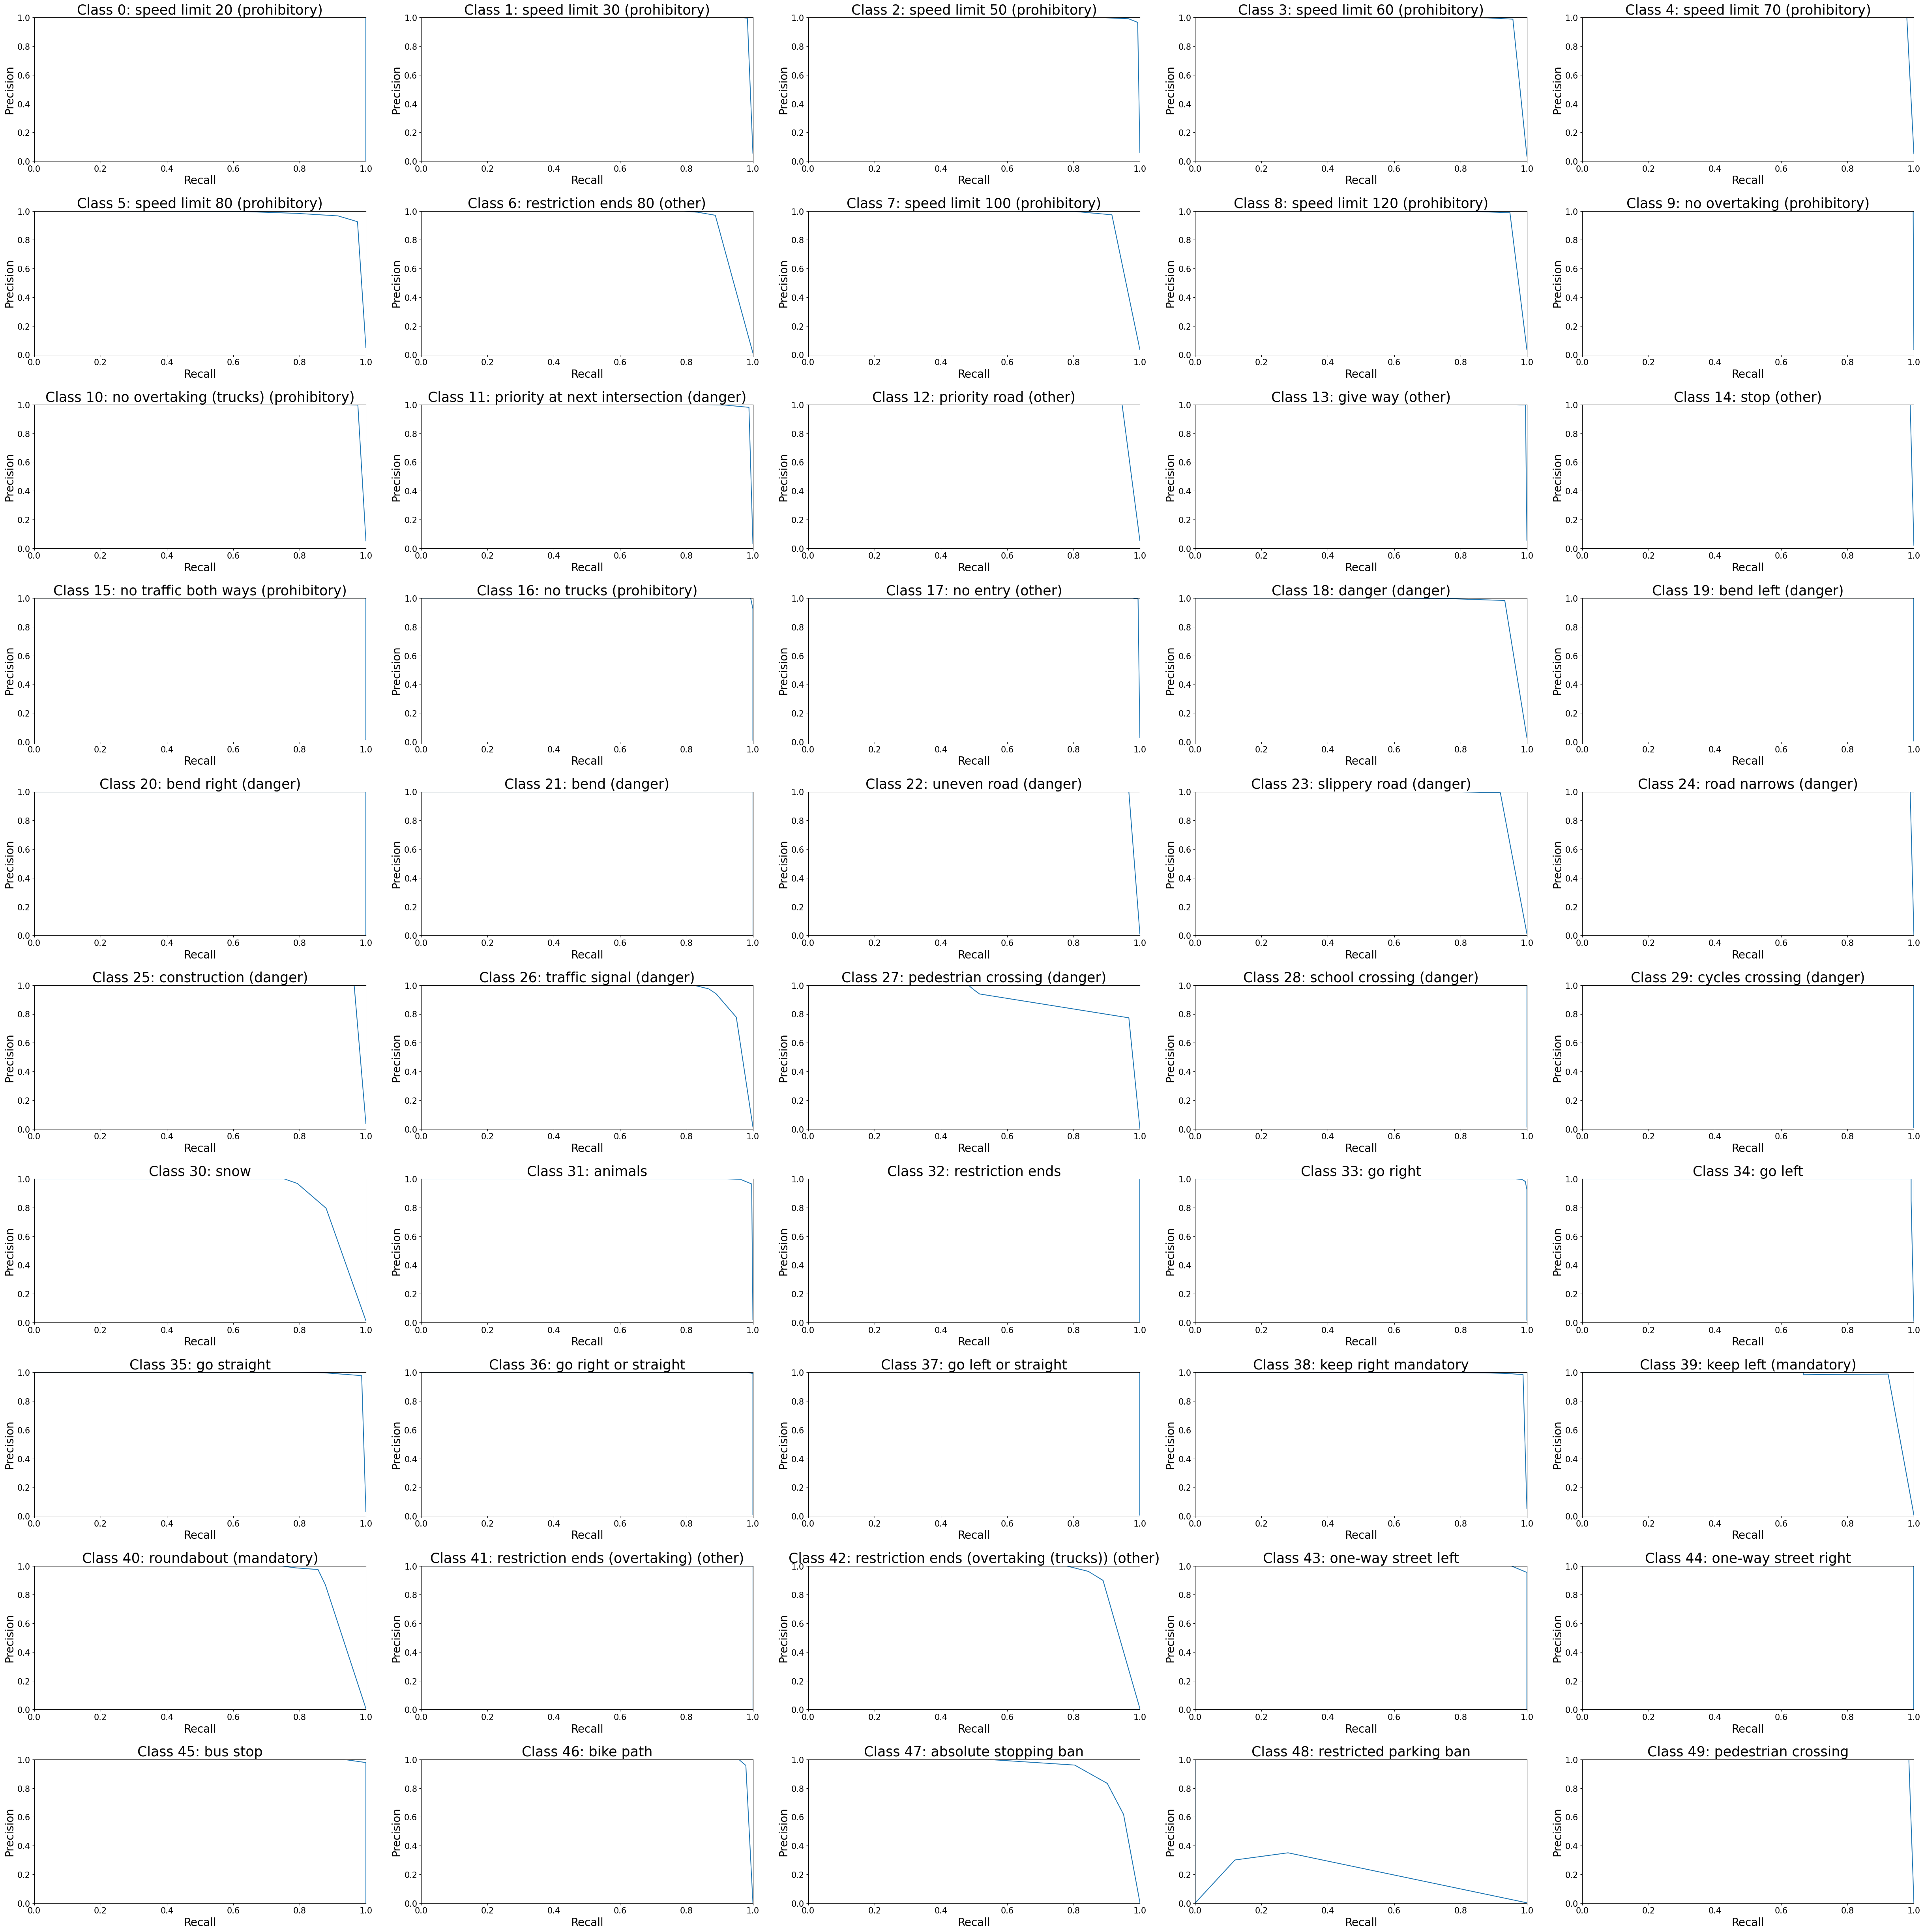

In [38]:
# # precision, recall for every threshold
thresholds = [0.0,0.2,0.4,0.6,0.8]
training.prec_recall(model, device, test_loader, orig_dataset.labels_dictionary, thresholds)

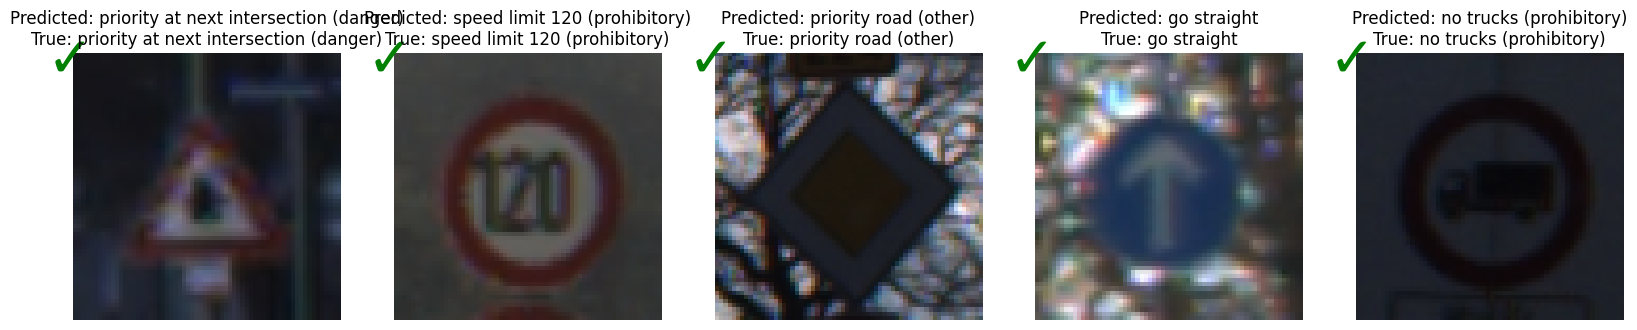

In [39]:
# show some examples:
training.show_random_examples(test_loader, test_history, orig_dataset.labels_dictionary, num_of_ex=5)

### Infer

In [40]:
transform_infer_data = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((SCALE, SCALE)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std),
])

def predict_and_visualize(model, infer_imgs, labels_dictionary, device):
    torch_input = torch.stack(infer_imgs).to(device)
    infer_output = model(torch_input)
    preds = infer_output.argmax(dim=1, keepdim=True)

    for ex in range(len(infer_imgs)):
        pred = preds[ex].cpu().detach().numpy()[0]
        label = labels_dictionary[pred]
        

        # Display the image using matplotlib
        img = infer_imgs[ex]
        print(f"Predicted Label: {label}")
        show(img)

In [41]:
# load images
infer_imgs = du.load_images_from_folder(PATH + '/test',transform=transform_infer_data)

92 images were read


Predicted Label: absolute stopping ban


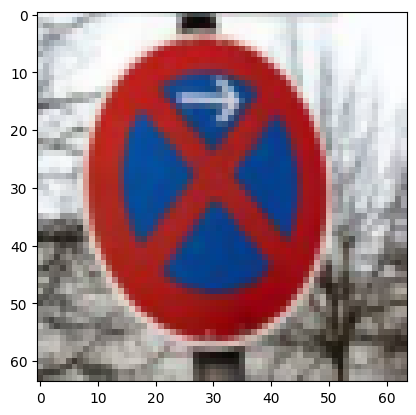

Predicted Label: one-way street right


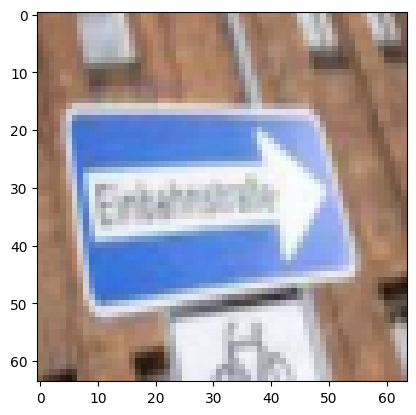

Predicted Label: one-way street right


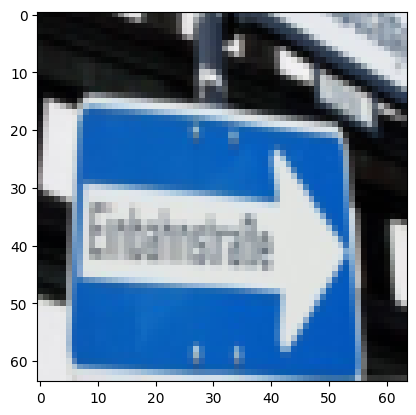

Predicted Label: one-way street left


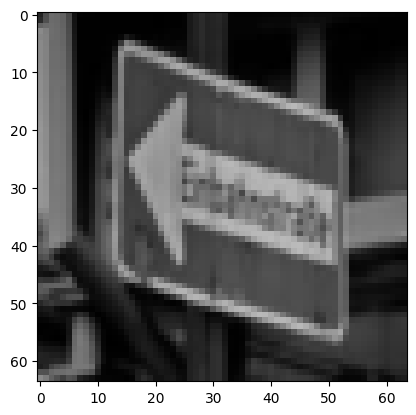

Predicted Label: one-way street left


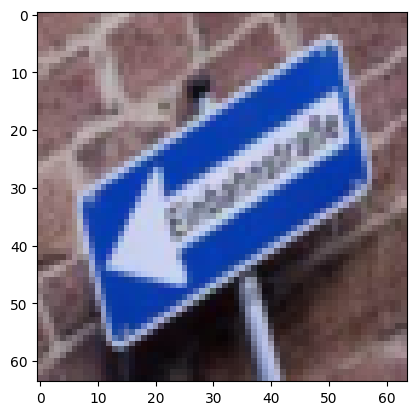

Predicted Label: one-way street left


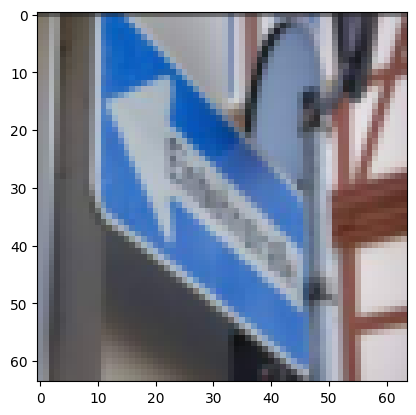

In [42]:
predict_and_visualize(model, infer_imgs[54:60], orig_dataset.labels_dictionary, device)